In [6]:
import os
import numpy as np
import scanpy as sc

In [84]:
root_path = '/home/mehrtash/data/pbmc_benchmark/SCP424'

counts_path = os.path.join(root_path, 'other', 'counts.umi.txt.gz')
genes_path = os.path.join(root_path, 'other', 'genes.umi.txt')
cells_path = os.path.join(root_path, 'other', 'cells.umi.new.txt')
meta_path = os.path.join(root_path, 'other', 'meta.counts.new.txt')
extra_meta_path = os.path.join(root_path, 'metadata', 'meta.txt')
harmony_path = os.path.join(root_path, 'cluster', 'tsne.harmony.txt')

In [7]:
from scipy.io import mmread

counts = mmread(counts_path)

In [ ]:
# load genes_path
with open(genes_path, 'r') as f:
    genes = f.read().splitlines()

In [11]:
len(genes)

33694

In [ ]:
# load cells_path
with open(cells_path, 'r') as f:
    cells = f.read().splitlines()

In [13]:
len(cells)

44433

In [18]:
import pandas as pd

meta_df = pd.read_csv(meta_path, sep='\t')

In [21]:
meta_df["Method"].value_counts()

Method
inDrops              11350
Drop-seq             11052
Seq-Well              5676
10x Chromium V2 A     5184
10x Chromium V3       4027
10x Chromium V2       3362
10x Chromium V2 B     3222
Smart-seq2             584
CEL-Seq2               560
Name: count, dtype: int64

In [22]:
len(meta_df) - 584

44433

In [28]:
# load extra metadata
extra_meta_df = pd.read_csv(extra_meta_path, sep='\t')

In [29]:
extra_meta_df

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method
0,TYPE,numeric,numeric,numeric,group,group,group,group
1,pbmc1_SM2_Cell_108,2200,437125,0.0297434465355702,0,Cytotoxic T cell,pbmc1,Smart-seq2
2,pbmc1_SM2_Cell_115,2438,335596,0.0311521658159055,0,Cytotoxic T cell,pbmc1,Smart-seq2
3,pbmc1_SM2_Cell_133,1874,302204,0.0431128105727693,0,Cytotoxic T cell,pbmc1,Smart-seq2
4,pbmc1_SM2_Cell_142,2480,377420,0.0260323569927476,0,Cytotoxic T cell,pbmc1,Smart-seq2
...,...,...,...,...,...,...,...,...
31017,pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA,453,717,0.097629009762901,11,Plasmacytoid dendritic cell,pbmc2,inDrops
31018,pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG,592,938,0.035181236673774,11,Plasmacytoid dendritic cell,pbmc2,inDrops
31019,pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA,406,662,0.138972809667674,11,Plasmacytoid dendritic cell,pbmc2,inDrops
31020,pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC,1001,2066,0.0556631171345595,11,Plasmacytoid dendritic cell,pbmc2,inDrops


In [ ]:
counts.shape

(33694, 44433)

In [75]:
ensembl_ids = [x.split('_')[0] for x in genes]
gene_symbols = [x.split('_')[1] for x in genes]
adata = sc.AnnData(
    X=counts.T.tocsr().astype(np.float32),
    obs=pd.DataFrame(index=cells),
    var=pd.DataFrame(index=ensembl_ids, data={'gene_symbols': gene_symbols}),
)
adata.obs.index.name = 'cell_id'

# subset anndata to only cells in extra_meta_df
adata = adata[adata.obs.index.isin(extra_meta_df['NAME'].values[1:])]

In [82]:
# extended_obs = pd.merge(left=adata.obs, right=meta_df, how='left', left_index=True, right_on='Name')
extended_obs = pd.merge(left=adata.obs, right=extra_meta_df, how='left', left_on='cell_id', right_on='NAME')
assert len(adata) == len(extended_obs)
adata.obs = extended_obs

In [ ]:
harmony_df = pd.read_csv(harmony_path, sep='\t', )

In [92]:
adata.obs = pd.merge(left=adata.obs, right=harmony_df, how='left', left_on='NAME', right_on='NAME')

In [97]:
harmony_n2 = np.zeros((len(adata.obs), 2))
harmony_n2[:, 0] = np.asarray(adata.obs['X'].values).astype(np.float32)
harmony_n2[:, 1] = np.asarray(adata.obs['Y'].values).astype(np.float32)
adata.obsm['X_harmony'] = harmony_n2

# drop X and Y from adata.obs
adata.obs = adata.obs.drop(columns=['X', 'Y'])

<Axes: title={'center': 'CellType'}, xlabel='X_harmony1', ylabel='X_harmony2'>

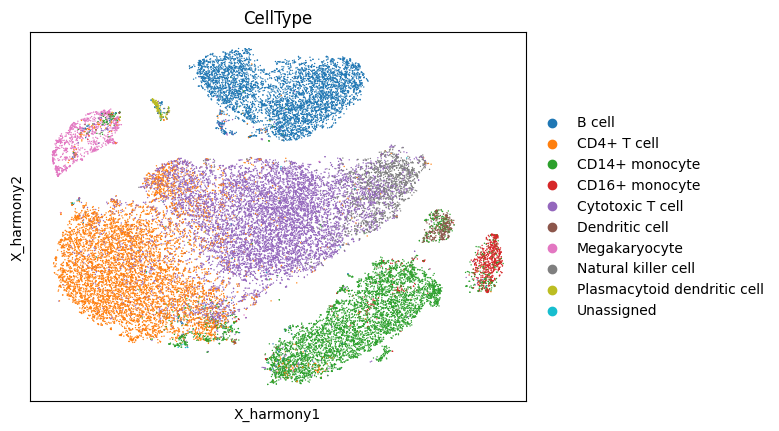

In [100]:
sc.pl.embedding(adata, basis='X_harmony', color='CellType', show=False)

In [102]:
adata.write(os.path.join(root_path, 'pbmc_adata.h5ad'))

### Playground

In [105]:
_adata = adata.copy()

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [106]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[<Axes: title={'center': 'CellType'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'Method'}, xlabel='X_umap1', ylabel='X_umap2'>]

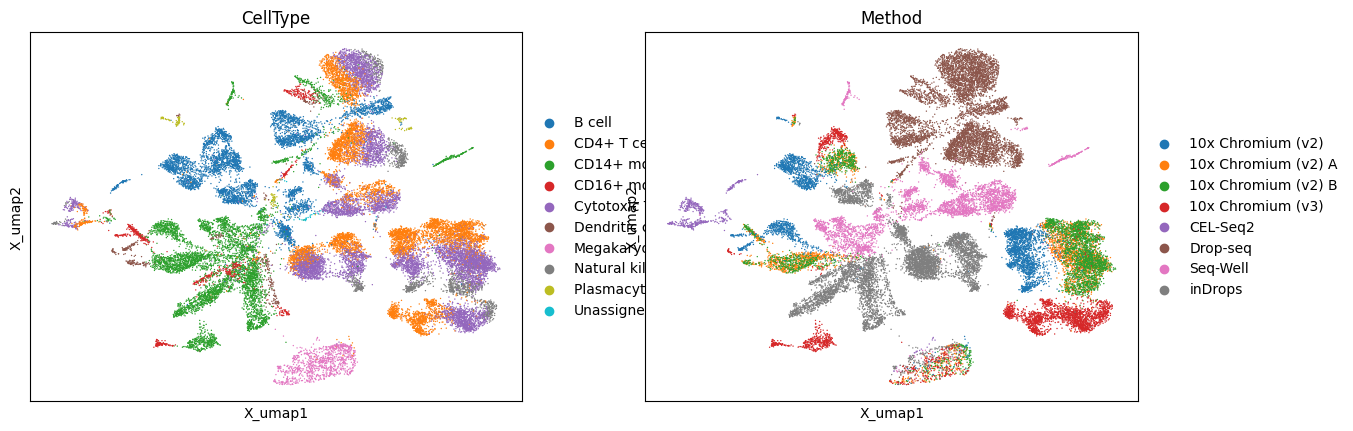

In [109]:
sc.pl.embedding(adata, basis='X_umap', color=['CellType', 'Method'], show=False)